# Identifying a Periodic Signal

In this tutorial, you will learn the fundamentals of using the provided neural network library for training a Moku Neural Network to deploy on Moku:Pro. This library uses the [Tensorflow](https://www.tensorflow.org/) implementation of [Keras](https://www.tensorflow.org/guide/keras) to instill best practices for deploying an FPGA-based neural network. In this example, we will train a basic model to analyze an input time series and identify whether the signal is a sine, square, or sawtooth wave, based on the output of three DC voltage signals. 

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import signal
from copy import copy
from tqdm import tqdm

from moku.nn import LinnModel, save_linn

# Step 1: Generate input (1 Channel) and output (3 Channels) data for training

Generate training data and plot the simulated signals to verify them. You can also choose to use Moku to produce training data.

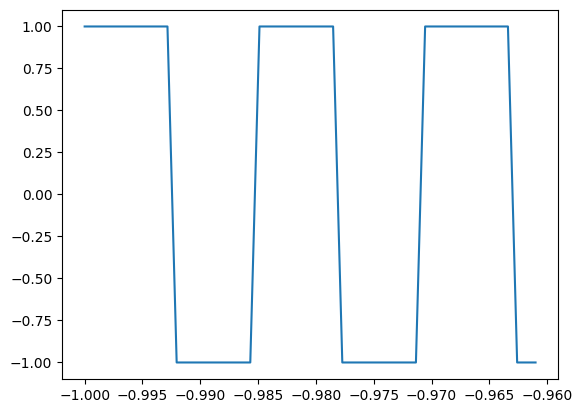

In [4]:
X = np.arange(0, np.pi*8, 0.01)
X_norm = np.linspace(-1, 1, len(X))

### gen_function will randomly pick one of three shapes within a bounded frequency range ###

def gen_function(input_array):
    func_type = random.randint(1,3)
    num_cycles = random.randrange(30,40)
    
    if func_type == 1:
        ### generate sine wave ###
        output_array = np.sin(num_cycles*input_array)
        answer = np.array((1,0,0))

    elif func_type == 2:
        ### generate square wave
        output_array = signal.square(num_cycles*input_array)
        answer = np.array((0,1,0))

    else:
        ### generate sawtooth wave
        output_array = signal.sawtooth(num_cycles*input_array)
        answer = np.array((0,0,1))
        
    return output_array, answer

### Plot for verification ### 
Y_norm, Y_answer = gen_function(X)
plt.plot(X_norm[0:50], Y_norm[0:50])
plt.show()

# Step 2: Defining the model and train the neural network

Now that we have defined the training data we need to define a model which we will then subsequently train. A neural network is made of succesive layers of connected neurons that implement a generally non-linear mapping of a linear transform: $A(Wx + b)$, where $W$ is the weight matrix, $x$ is an input vector, $b$ is a bias vector and $A$ is the activation function. By successively stacking and connecting arbitrarily large numbers of artificial neurons, a neural network becomes a unviersal approximator. While there are many different types of neural networks, the Moku FPGA currently only supports densely connected feedforward networks. More information on these type of networks, otherwise known as multilayer perceptrons, can be found here: [Goodfellow-Ch6](https://www.deeplearningbook.org/contents/mlp.html).

In the code below, we generate a given number of training sets and put them into a matrix. We also reshape the data to reflect that we have N number of training examples of size 100 (the "batch size", which is the maximum numbers of points that can be analyzed at one time using an input time series. In general, training data should allow for the mapping $(N, M)\mapsto(N, K)$ where N is the number of training examples, M is the input feature dimension and K is the output feature dimension. In this case, we reshape the data so that the M is 100 and K is 3. 


In [7]:
### number of training sets to generate ###
dr = 1000

training_data = np.zeros((dr, X_norm.size))

training_answers = np.zeros((dr, 3))

print(training_data.shape)
print(training_answers.shape)

### We will run our previously-defined "gen_function" to generate multiple sets of training data and place these and the answers into a matrix ###
for idx in tqdm(range(dr)):
    Y_norm, Y_answer = gen_function(X)
    training_data[idx, :] = Y_norm
    training_answers[idx,:] = Y_answer

(1000, 2514)
(1000, 3)


100%|██████████| 1000/1000 [00:00<00:00, 7689.86it/s]


100%|██████████| 1000/1000 [00:00<00:00, 58774.21it/s]

(25000, 100)
(25000, 3)
[1. 0. 0.]


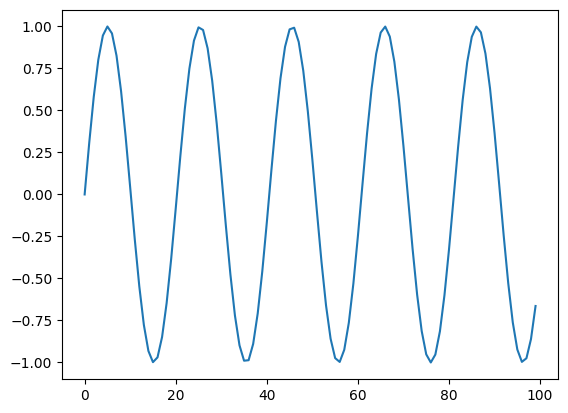

In [8]:
### waveform batch size - maximum 100 ### 
bs = 100

N = X_norm.size
training_batched = []
answers_batched = []
for j in tqdm(range(training_data.shape[0])):
    for idx in range(0, N, bs):
        if idx+bs < N:
            training_batched.append(training_data[j, idx:idx+bs])
            answers_batched.append(training_answers[j])

training_batched = np.array(training_batched)
answers_batched = np.array(answers_batched)
print(training_batched.shape)
print(answers_batched.shape)

### plot a random piece of training data and give answer to confirm ### 
plt.plot(training_batched[20000,:])
print(answers_batched[20000,:])

In [22]:
# create the quantised model object and set the training data
quant_mod = LinnModel()
quant_mod.set_training_data(training_inputs=training_batched, training_outputs=answers_batched, scale=False)

In [23]:
# model definition for a signal ID
model_definition = [(bs,'relu'), (64, 'relu'),(32, 'relu'),(8, 'relu'),(3,'sigmoid')]
# build the model
quant_mod.construct_model(model_definition, show_summary=True)
history = quant_mod.fit_model(epochs=1000, es_config={'monitor': 'val_loss', 'patience':20}, validation_split=0.1)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_20            │ (None, 100)            │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_21            │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_22            │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_23            │ (None, 8)              │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_24            │ (None, 3)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,935 (73.96 KB)

 Trainable params: 18,935 (73.96 KB)

 Non-trainable params: 0 (0.00 B)

Value for restore missing. Using default:False.


Epoch 1/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1282 - val_loss: 0.0222
Epoch 2/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: 0.0184 - val_loss: 0.0132
Epoch 3/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - loss: 0.0120 - val_loss: 0.0110
Epoch 4/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.0105 - val_loss: 0.0102
Epoch 5/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - loss: 0.0100 - val_loss: 0.0101
Epoch 6/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 7/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 8/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 9/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 10/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 11/1000
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 12/1

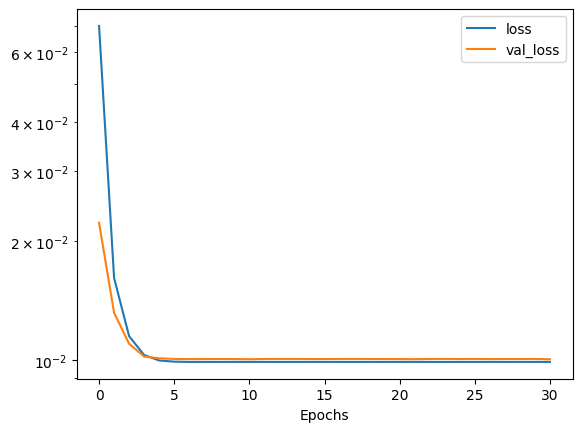

In [24]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [28]:
### Generate a few more examples and test the predictions ### 

for i in range(0,10):
    Y_norm, Y_answer = gen_function(X)
    
    preds = quant_mod.predict(Y_norm[0:bs].reshape(1,-1), scale=False, unscale_output=False)
    print(Y_answer)
    print(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0 1 0]
[0.11678687 0.909822   0.04604319]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1 0 0]
[0.87811184 0.06365319 0.11598239]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0 1 0]
[0.11678687 0.909822   0.04604319]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0 0 1]
[0.1189811  0.06365319 0.8774995 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0 1 0]
[0.11678687 0.909822   0.04604319]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0 0 1]
[0.1189811  0.06365319 0.8774995 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0 0 1]
[0.1189811  0.06365319 0.8774995 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[1 0 0]
[0.87811184 0.06365319 0.11598239]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0 0 1]
[0.1189811  0.06365319 0.8774995 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0 1 0]
[0.11678687 0.909822   0.04604319]


# Step 3: Save the model to disk for use in the Moku Neural Network instrument.


In [29]:
save_linn(quant_mod.model, input_channels=1, output_channels=3, file_name='SigID.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 10 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 319 cycles
